### <center>Moview Review Binary Classification in Jupyter</center>
<center>Big Data Analytics - Analysis of Text and Social Media Data: Group Project Week-2</center>
<center>ePGD ABA 2020-21</center>

**Group-3 includes : Nitin Raheja, Rohan Singh, Anand Dattani, and Arimitra Maiti**

**CAUTION - This notebook takes roughly 15 minutes to complete execution \
This notebook may not run end to end in google colab environment or mac environment \
.tar.gz file needs to saved locally in windows machine \
The text documents would be collated from locally**

**Important Input from user: Please set the location of .tar.gz file in the below cell**

In [1]:
###The path where user is saving the .tar.gz file
###Need to use single forward slash instead of back slash - applicable only for windows OS
save_targz_file = "C:/Users/sinaii/Documents/Arimitra_Maiti/IIM-A Docs/NLP/Week-2-GA/movie_reviews_pang_lee.tar.gz"

In [2]:
##Import basic modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import scipy.stats as stats
import math
import sys

In [3]:
import tarfile
import codecs
import os
import glob

In [4]:
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt

import nltk
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

In [5]:
from bs4 import BeautifulSoup
import re
from tqdm import tqdm_notebook
from tqdm import tqdm
import string

In [6]:
##Need to comment out as soon as the first complete notebook has finished its run
##else we need to delete the extracted flder from locally and then re-run


# tar = tarfile.open(save_targz_file, "r:gz", encoding='utf-8')
# tar.extractall()

**Collection of negative and positive sentiments from local folder**

In [7]:
##Not applicable for colab environment
##Not applicable if it is expected to extract files directly from targz file in one single loop

###Start extracting negative sentiments from local folder
current_dir = os.getcwd()

y = current_dir + "\\txt_sentoken\\neg"

new_dir = y
filelist = []
filesList = []
os.chdir(new_dir)

for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filesList.append(files) #filename with extension

neg = []
for k in filesList:
    f=open(k,'r', encoding="utf=8")
    raw=f.read()
    raw=(''.join(raw))
    raw = raw.replace('\r', '').replace('\n', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('-', '')
    raw = raw.replace(':', '')
    raw = raw.replace('..', '')
    neg.append(raw)

neg_df = pd.DataFrame(neg, columns=['text'])
neg_df['tag'] = 'negative'
del filesList, fileName, fileExtension, y, new_dir

os.chdir(current_dir)
###Start extracting positive sentiments from local folder
y = os.getcwd() + "\\txt_sentoken\\pos"
y

new_dir = y
filelist = []
filesList = []
os.chdir(new_dir)

for files in glob.glob("*.txt"):
    fileName, fileExtension = os.path.splitext(files)
    filesList.append(files) #filename with extension

pos = []
for k in filesList:
    f=open(k,'r', encoding="utf=8")
    raw=f.read()
    raw=(''.join(raw))
    raw = raw.replace('\r', '').replace('\n', '')
    raw = raw.replace('(', '')
    raw = raw.replace(')', '')
    raw = raw.replace('-', '')
    raw = raw.replace(':', '')
    raw = raw.replace('..', '')
    pos.append(raw)

pos_df = pd.DataFrame(pos, columns=['text'])
pos_df['tag'] = 'positive'
del filesList, fileName, fileExtension, y, new_dir

os.chdir(current_dir)
os.getcwd()

'C:\\Users\\sinaii\\Documents\\Python Scripts\\NLP'

In [8]:
df = pd.concat([pos_df, neg_df], axis=0)
df.reset_index(inplace=True, drop=True)

In [9]:
del pos_df, neg_df

**Data Cleaning**

In [10]:
##Check if NaN values are there and if yes then collect row indices
blanks = []
for index, label, review in df.itertuples():
    if type(review)==str:
        if review.isspace():
            blanks.append(index)
        
print(len(blanks), 'blanks: ', blanks)

0 blanks:  []


In [11]:
my_stop_list = ['movie', 'film', 'movies', 'films', 'cinema', 'review', 'reviews', 'rating', 'ratings']

In [12]:
stop_set = set(nltk.corpus.stopwords.words('english'))
stop_punctuation = set(list(string.punctuation))
stop_set.update(stop_punctuation)
stop_set.update(my_stop_list)

In [13]:
##Use Beautiful soup to remove html tags
##Use regex to replace "< br / >" with blanks
##Use regex to replace special characters with blanks
##Split each word of a row
##Perform default and custom stopword checklist
##Rejoin the set of words for each row
##Append the clean set of text in a list

clean_text = []
for i in tqdm(range(df.shape[0])):
    soup = BeautifulSoup(df['text'].loc[i], "html.parser")
    text = soup.get_text()
    text = re.sub('\<br />', '', text)
    text = re.sub('[^a-zA-z0-9\s]', '', text)
    text = text.lower()
    text = text.split()
    text = [word for word in text if not word in stop_set]
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text]
    text = ' '.join(text)
    clean_text.append(text)

100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:09<00:00, 205.20it/s]


In [14]:
df_processed = pd.DataFrame(clean_text,columns=['review_processed'])
dataset_new = pd.concat([df, df_processed], axis=1)
dataset_new.drop(labels=['text'], inplace=True, axis=1)
dataset_new.head(2)

,tag,review_processed
0,positive,adapted comic book plenty success whether they...
1,positive,every come along suspect studio every indicati...


**Word2vec feature extraction**

In [15]:
# !python -m pip install -U gensim

In [16]:
###First time download may take upto 30 minutes
##Download google word2vec pre trained model from gensim
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [17]:
##Create unique set of words from google model
vocabulary = set(wv.index2word)

In [18]:
##Dimension of each word
embedding_size = wv.vector_size

In [19]:
print("Model contains %d words" %len(vocabulary))

Model contains 3000000 words


In [20]:
print("Each word is represented by a %d dimensional vector" %embedding_size)

Each word is represented by a 300 dimensional vector


In [21]:
##Create X and y attrs, X here has only one column from the explicit dataset
##We are yet to form the features
X, y = dataset_new['review_processed'], dataset_new['tag']
sdict = {'positive': 1, 'negative': 0}
y = y.map(sdict)
X.shape, y.shape

((2000,), (2000,))

In [22]:
##Define word2vec function where mean of the vectors would be considered if the word exists Else zero
def mean_vector(review):
    zero = np.zeros((embedding_size,), dtype="float32")
    if pd.isnull(review):
        return zero
    words = [w for w in review.split() if w in vocabulary]
    if not words:
        return zero
    return np.mean([wv[w] for w in words], axis=0)

In [23]:
cols = ['v_'+str(i) for i in range(embedding_size)]

In [24]:
dfV = pd.DataFrame(list(map(mean_vector, X)), columns=cols)

In [25]:
X, y = dfV, y
X.shape, y.shape

((2000, 300), (2000,))

**Creation of Train, Validation and Test sets**

In [26]:
##Import split module
from sklearn.model_selection import train_test_split

In [27]:
##Divide total rows into 80:20 and keep the 20 for test
##Push 40% to test data
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

X_data.shape, X_test.shape, y_data.shape, y_test.shape

((1600, 300), (400, 300), (1600,), (400,))

In [28]:
##Further Divide total rows of the 80 above, into 80:20 and keep the 20 for validation
X = X_data.copy()
y = y_data.copy()
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify=y)

X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1280, 300), (320, 300), (1280,), (320,))

In [29]:
##Class imbalance proportion of train set
round((np.unique(y_train, return_counts=True)[1][1]/(np.unique(y_train, return_counts=True)[1][0]+np.unique(y_train, return_counts=True)[1][1]))*100,2)

50.0

In [30]:
##Class imbalance proportion of validation set
round((np.unique(y_valid, return_counts=True)[1][1]/(np.unique(y_valid, return_counts=True)[1][0]+np.unique(y_valid, return_counts=True)[1][1]))*100,2)

50.0

In [31]:
##Class imbalance proportion of test set
round((np.unique(y_test, return_counts=True)[1][1]/(np.unique(y_test, return_counts=True)[1][0]+np.unique(y_test, return_counts=True)[1][1]))*100,2)

50.0

In [32]:
##Sum of train set and validation set must match the rows of initial split
(X_train.shape[0] + X_valid.shape[0]) == X_data.shape[0]

True

In [33]:
##Sum of all sets must match the rows of imported file
(X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]) == dataset_new.shape[0]

True

In [34]:
##Free up some memory
del df_processed, dataset_new, dfV, X_data, y_data, X, y

**Constant, Quasi Constant and Duplicate features**

In [35]:
##check if any numerical features have any constant variance, i.e. standard deviation as zero
store = []
for i in range(len(X_train.columns)):
    if X_train[X_train.columns[i]].dtype != 'object':
        varname = X_train.columns[i]
        store.append(varname)

constant_features = [x for x in store if X_train[x].std() == 0]

X_train.drop(labels=constant_features, axis=1, inplace=True)
X_valid.drop(labels=constant_features, axis=1, inplace=True)
X_test.drop(labels=constant_features, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(1280, 300) (320, 300) (400, 300)


In [36]:
del store

In [37]:
# create an empty list
quasi_constant_feat = []

# iterate over every attributes in the train set including numerical and object variables
for k in X_train.columns:
    # find the dominant value, that is the value that is shared by most observations
    predominant = (X_train[k].value_counts() / np.float(
        len(X_train))).sort_values(ascending=False).values[0]

    # evaluate the dominant feature: do more than 99% of the observations show 1 single value?
    if predominant > 0.998:
        
        # if yes, add the variable to the list
        quasi_constant_feat.append(k)

len(quasi_constant_feat)

0

In [38]:
quasi_constant_feat

[]

In [39]:
X_train.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_valid.drop(labels=quasi_constant_feat, axis=1, inplace=True)
X_test.drop(labels=quasi_constant_feat, axis=1, inplace=True)

print(X_train.shape, X_valid.shape, X_test.shape)

(1280, 300) (320, 300) (400, 300)


In [40]:
##Check if we have features that despite having different names, are identical.
# check for duplicated features in the training set:

# create an empty dictionary, where we will store 
# the groups of duplicates
duplicated_feat_pairs = {}

# create an empty list to collect features
# that were found to be duplicated
_duplicated_feat = []


# iterate over every feature in our dataset:
for i in range(0, len(X_train.columns)):
    
    # this bit helps me understand where the loop is at:
    if i % 10 == 0:  
        print(i)
    
    # choose 1 feature:
    feat_1 = X_train.columns[i]
    
    # check if this feature has already been identified
    # as a duplicate of another one. If it was, it should be stored in
    # our _duplicated_feat list.
    
    # If this feature was already identified as a duplicate, we skip it, if
    # it has not yet been identified as a duplicate, then we proceed:
    if feat_1 not in _duplicated_feat:
    
        # create an empty list as an entry for this feature in the dictionary:
        duplicated_feat_pairs[feat_1] = []

        # now, iterate over the remaining features of the dataset:
        for feat_2 in X_train.columns[i + 1:]:

            # check if this second feature is identical to the first one
            if X_train[feat_1].equals(X_train[feat_2]):

                # if it is identical, append it to the list in the dictionary
                duplicated_feat_pairs[feat_1].append(feat_2)
                
                # and append it to our monitor list for duplicated variables
                _duplicated_feat.append(feat_2)
                
                # done!

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [41]:
## If length is positive then we do have some duplicated features
len(_duplicated_feat)
# duplicated_feat_pairs

0

In [42]:
import xgboost as xgb
from sklearn.feature_selection import RFECV
from lightgbm import LGBMClassifier
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, f1_score

In [43]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

from sklearn.ensemble import GradientBoostingClassifier

**Feature Selection**

In [44]:
##SelectFromModel using Light GBM
# sel_ = SelectFromModel(
#     LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
#                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40
#                    ))

# sel_.fit(X_train, y_train.values.flatten())

# selected_attr = X_train.columns[(sel_.get_support())]

# len(selected_attr)

# pd.Series(sel_.estimator_.feature_importances_.ravel()).hist(bins=20)
# plt.xlabel('Feature importance')
# plt.ylabel('Number of Features')
# plt.show()

# print('total features: {}'.format((X_train.shape[1])))

# print('selected features: {}'.format(len(selected_attr)))

# print(
#     'features with importance greater than the mean importance of all features: {}'.format(
#         np.sum(sel_.estimator_.feature_importances_ >
#                sel_.estimator_.feature_importances_.mean())))

# selected_attr

In [45]:
##Somehow sns.set(font_scale = 5) is giving clear images of feature importance but resettig other plot options
def plotImp(model, X , num = 20, text="ABC"):
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    plt.figure(figsize=(40, 20))
    sns.set(font_scale = 5)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title(text)
    plt.tight_layout()
    plt.show()

In [46]:
# plotImp(sel_.estimator_, X_train, num=20, text='SelectFromModel-Light GBM')

In [47]:
##RFECV using Light GBM
# sel_ = RFECV(LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
#                    reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40, random_state=10
#                    ),
#              min_features_to_select=10, step=5, scoring="f1_micro")

# sel_.fit(X_train, y_train.values.flatten())

# selected_attr = X_train.columns[(sel_.get_support())]
# len(selected_attr)

In [48]:
# print(*selected_attr, sep = ", ")

In [49]:
###Feature importance using LightGBM
list1 = [
    'v_2', 'v_5', 'v_6', 'v_8', 'v_12', 'v_14', 'v_16', 'v_17', 'v_24', 'v_26', 'v_33', 'v_37', 'v_38', 'v_42',
    'v_43', 'v_45', 'v_50', 'v_55', 'v_56', 'v_57', 'v_60', 'v_69', 'v_72', 'v_74', 'v_76', 'v_82', 'v_86', 'v_92',
    'v_94', 'v_99', 'v_100', 'v_102', 'v_106', 'v_108', 'v_121', 'v_122', 'v_129', 'v_139', 'v_141', 'v_142', 'v_143',
    'v_144', 'v_146', 'v_149', 'v_157', 'v_169', 'v_171', 'v_172', 'v_176', 'v_177', 'v_179', 'v_182', 'v_183', 'v_184',
    'v_185', 'v_191', 'v_193', 'v_195', 'v_198', 'v_203', 'v_204', 'v_207', 'v_209', 'v_210', 'v_213', 'v_220', 'v_223',
    'v_226', 'v_227', 'v_230', 'v_238', 'v_240', 'v_243', 'v_245', 'v_246', 'v_247', 'v_248', 'v_251', 'v_256', 'v_259',
    'v_260', 'v_261', 'v_262', 'v_263', 'v_266', 'v_267', 'v_270', 'v_271', 'v_273', 'v_274', 'v_278', 'v_281', 'v_282',
    'v_288', 'v_289', 'v_291'
]

In [50]:
###Feature selection using RFECV LightGBM
list2 = [
    'v_0', 'v_2', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_12', 'v_14', 'v_16', 'v_17', 'v_23', 'v_24', 'v_26', 'v_33', 'v_36',
    'v_37', 'v_38', 'v_39', 'v_42', 'v_43', 'v_45', 'v_50', 'v_51', 'v_53', 'v_55', 'v_56', 'v_60', 'v_61', 'v_65', 'v_66',
    'v_68', 'v_69', 'v_70', 'v_72', 'v_73', 'v_74', 'v_76', 'v_78', 'v_79', 'v_82', 'v_84', 'v_86', 'v_87', 'v_88', 'v_89',
    'v_92', 'v_94', 'v_99', 'v_100', 'v_102', 'v_106', 'v_108', 'v_111', 'v_116', 'v_117', 'v_120', 'v_121', 'v_122', 'v_129',
    'v_138', 'v_139', 'v_140', 'v_141', 'v_142', 'v_143', 'v_144', 'v_146', 'v_149', 'v_151', 'v_154', 'v_156', 'v_157', 'v_159',
    'v_165', 'v_166', 'v_169', 'v_171', 'v_172', 'v_173', 'v_176', 'v_177', 'v_179', 'v_182', 'v_183', 'v_184', 'v_185', 'v_191',
    'v_193', 'v_195', 'v_197', 'v_198', 'v_202', 'v_203', 'v_204', 'v_207', 'v_208', 'v_209', 'v_210', 'v_212', 'v_213',
    'v_215', 'v_220', 'v_223', 'v_226', 'v_227', 'v_229', 'v_230', 'v_231', 'v_234', 'v_238', 'v_240', 'v_241', 'v_242',
    'v_243', 'v_245', 'v_246', 'v_247', 'v_248', 'v_249', 'v_251', 'v_256', 'v_259', 'v_260', 'v_261', 'v_262', 'v_263', 'v_264',
    'v_266', 'v_267', 'v_270', 'v_271', 'v_273', 'v_274', 'v_278', 'v_280', 'v_281', 'v_282', 'v_284', 'v_288', 'v_289',
    'v_291', 'v_293', 'v_295', 'v_298'
]

In [51]:
big_list = [list1, list2]

result = [item for sublist in big_list for item in sublist]

result = pd.DataFrame(result, columns=['items'])

result = result.sort_values(by=['items'], ascending=False)

result = result['items'].value_counts()>1

result = pd.DataFrame(result)

algo_features = result[result['items']==True].index.tolist()

In [52]:
X_train = X_train[algo_features]
X_valid = X_valid[algo_features]
X_test = X_test[algo_features]

print(X_train.shape, X_valid.shape, X_test.shape)

(1280, 95) (320, 95) (400, 95)


**Scaling**

In [53]:
##Import scaling module
from sklearn.preprocessing import MinMaxScaler

##Train the scaler in trainset
sc = MinMaxScaler()
sc.fit(X_train)

##Fit the scaler to all sets
X_train_scaled = sc.transform(X_train)
X_valid_scaled = sc.transform(X_valid)
X_test_scaled = sc.transform(X_test)

In [54]:
y_train_series = pd.Series(y_train.values.flatten())
y_valid_series = pd.Series(y_valid.values.flatten())

In [55]:
y_test_series = pd.Series(y_test.values.flatten())

_Function to plot learning curves - borrowed from open forum_

In [56]:
###Function to plot learning curves post model training
def plot_learning_curves(estimator, X_train, y_train, X_val, y_val,
                         suptitle='', title='', xlabel='', ylabel=''):
    """
    Plots learning curves for a given estimator.

    Parameters
    ----------

    estimator : sklearn estimator
    X_train : pd.DataFrame
        training set (features)
    y_train : pd.Series
        training set (response)
    X_val : pd.DataFrame
        validation set (features)
    y_val : pd.Series
        validation set (response)
    suptitle : str
        Chart suptitle
    title: str
        Chart title
    xlabel: str
        Label for the X axis
    ylabel: str
        Label for the y axis

    Returns
    -------

    Plot of learning curves
    """
    

    # create lists to store train and validation scores
    train_score = []
    val_score = []
    # create ten incremental training set sizes
    training_set_sizes = np.linspace(5, len(X_train), 10, dtype='int')

    # for each one of those training set sizes
    for i in training_set_sizes:
        # fit the model only using that many training examples
        estimator.fit(X_train.iloc[0:i, :], y_train.iloc[0:i])
        # calculate the training accuracy only using those training examples
        train_accuracy = f1_score(
                                    y_train.iloc[0:i],
                                    estimator.predict(X_train.iloc[0:i, :])
                                    )
        # calculate the validation accuracy using the whole validation set
        val_accuracy = f1_score(
                                    y_val,
                                    estimator.predict(X_val)
                                    )
        # store the scores in their respective lists
        train_score.append(train_accuracy)
        val_score.append(val_accuracy)
        
    # plot learning curves
    fig, ax = plt.subplots(figsize=(15, 6))
    ax.plot(training_set_sizes, train_score, c='gold')
    ax.plot(training_set_sizes, val_score, c='steelblue')

    # format the chart to make it look nice
    fig.suptitle(suptitle, fontweight='bold', fontsize='20')
    ax.set_title(title, size=20)
    ax.set_xlabel(xlabel, size=16)
    ax.set_ylabel(ylabel, size=16)
    ax.legend(['training set', 'validation set'], fontsize=16)
    ax.tick_params(axis='both', labelsize=12)
    ax.set_ylim(0, 1)

    def percentages(x, pos):
        """The two args are the value and tick position"""
        if x < 1:
            return '{:1.0f}'.format(x*100)
        return '{:1.0f}%'.format(x*100)

    def numbers(x, pos):
        """The two args are the value and tick position"""
        if x >= 1000:
            return '{:1,.0f}'.format(x)
        return '{:1.0f}'.format(x)

    y_formatter = percentages
    ax.yaxis.set_major_formatter(y_formatter)

    x_formatter = numbers
    ax.xaxis.set_major_formatter(x_formatter)

In [57]:
import time

**Light GBM Classifier**

In [58]:
###Training of Light GBM
##First phase
# estimator = LGBMClassifier(boosting_type ="goss",
#                            objective = "binary",
#                            random_state=10,
#                            min_split_gain=0.01,
#                            importance_type = "gain",
#                            n_jobs=-1)

# def lgb_parameter(X_data, y_data):
#     learning_rate = np.arange(0.01,1,0.05)
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 55, 11)]
#     colsample_bytree = [0.3, 0.5, 0.8, 1.0]
#     reg_alpha = [0, 0.5, 1]
#     reg_lambda = [1, 1.5, 2, 3, 4.5, 5]
#     num_leaves = np.linspace(10, 200, 10, dtype=np.int32)
#     param_grid = {'learning_rate': learning_rate,
#                   'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'colsample_bytree' : colsample_bytree,
#                   'reg_alpha' : reg_alpha,
#                   'reg_lambda' : reg_lambda,
#                   'num_boost_round' : [500], 
#                   'early_stopping_rounds' : [10],
#                   "num_leaves" : num_leaves}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=StratifiedKFold(10, shuffle=True, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=1,
#                             n_iter=50)
#     gs.fit(X_data, y_data, eval_set=[(X_valid_scaled, y_valid_series)])
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = lgb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [59]:
# Best parameters: {'reg_lambda': 4.5,
#                   'reg_alpha': 0.5,
#                   'num_leaves': 73,
#                   'num_boost_round': 500,
#                   'n_estimators': 262,
#                   'max_depth': 40,
#                   'learning_rate': 0.060000000000000005,
#                   'early_stopping_rounds': 10, 'colsample_bytree': 0.3}

In [60]:
estimator1 = LGBMClassifier(boosting_type ="goss",
                           objective = "binary",
                           random_state=10,
                           min_split_gain=0.01,
                           importance_type = "gain",
                           n_jobs=-1, reg_alpha=0.5, reg_lambda=4.5,
                           num_leaves=73, n_estimators=262, max_depth=40, learning_rate=0.06, colsample_bytree=0.3)

In [61]:
sns.set(font_scale = 1)

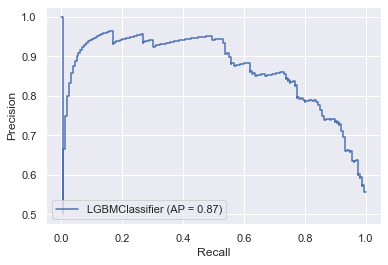

In [62]:
estimator1.fit(X_train_scaled, y_train_series)
prcurve_lgb = plot_precision_recall_curve(estimator1, X_valid_scaled, y_valid_series)

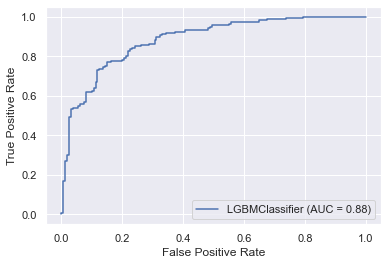

In [63]:
plot_roc_curve(estimator1, X_valid_scaled, y_valid_series)

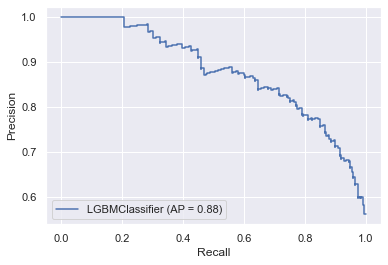

In [64]:
prcurve_lgb_test = plot_precision_recall_curve(estimator1, X_test_scaled, y_test_series)

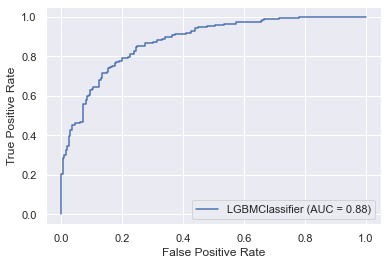

In [65]:
plot_roc_curve(estimator1, X_test_scaled, y_test_series)

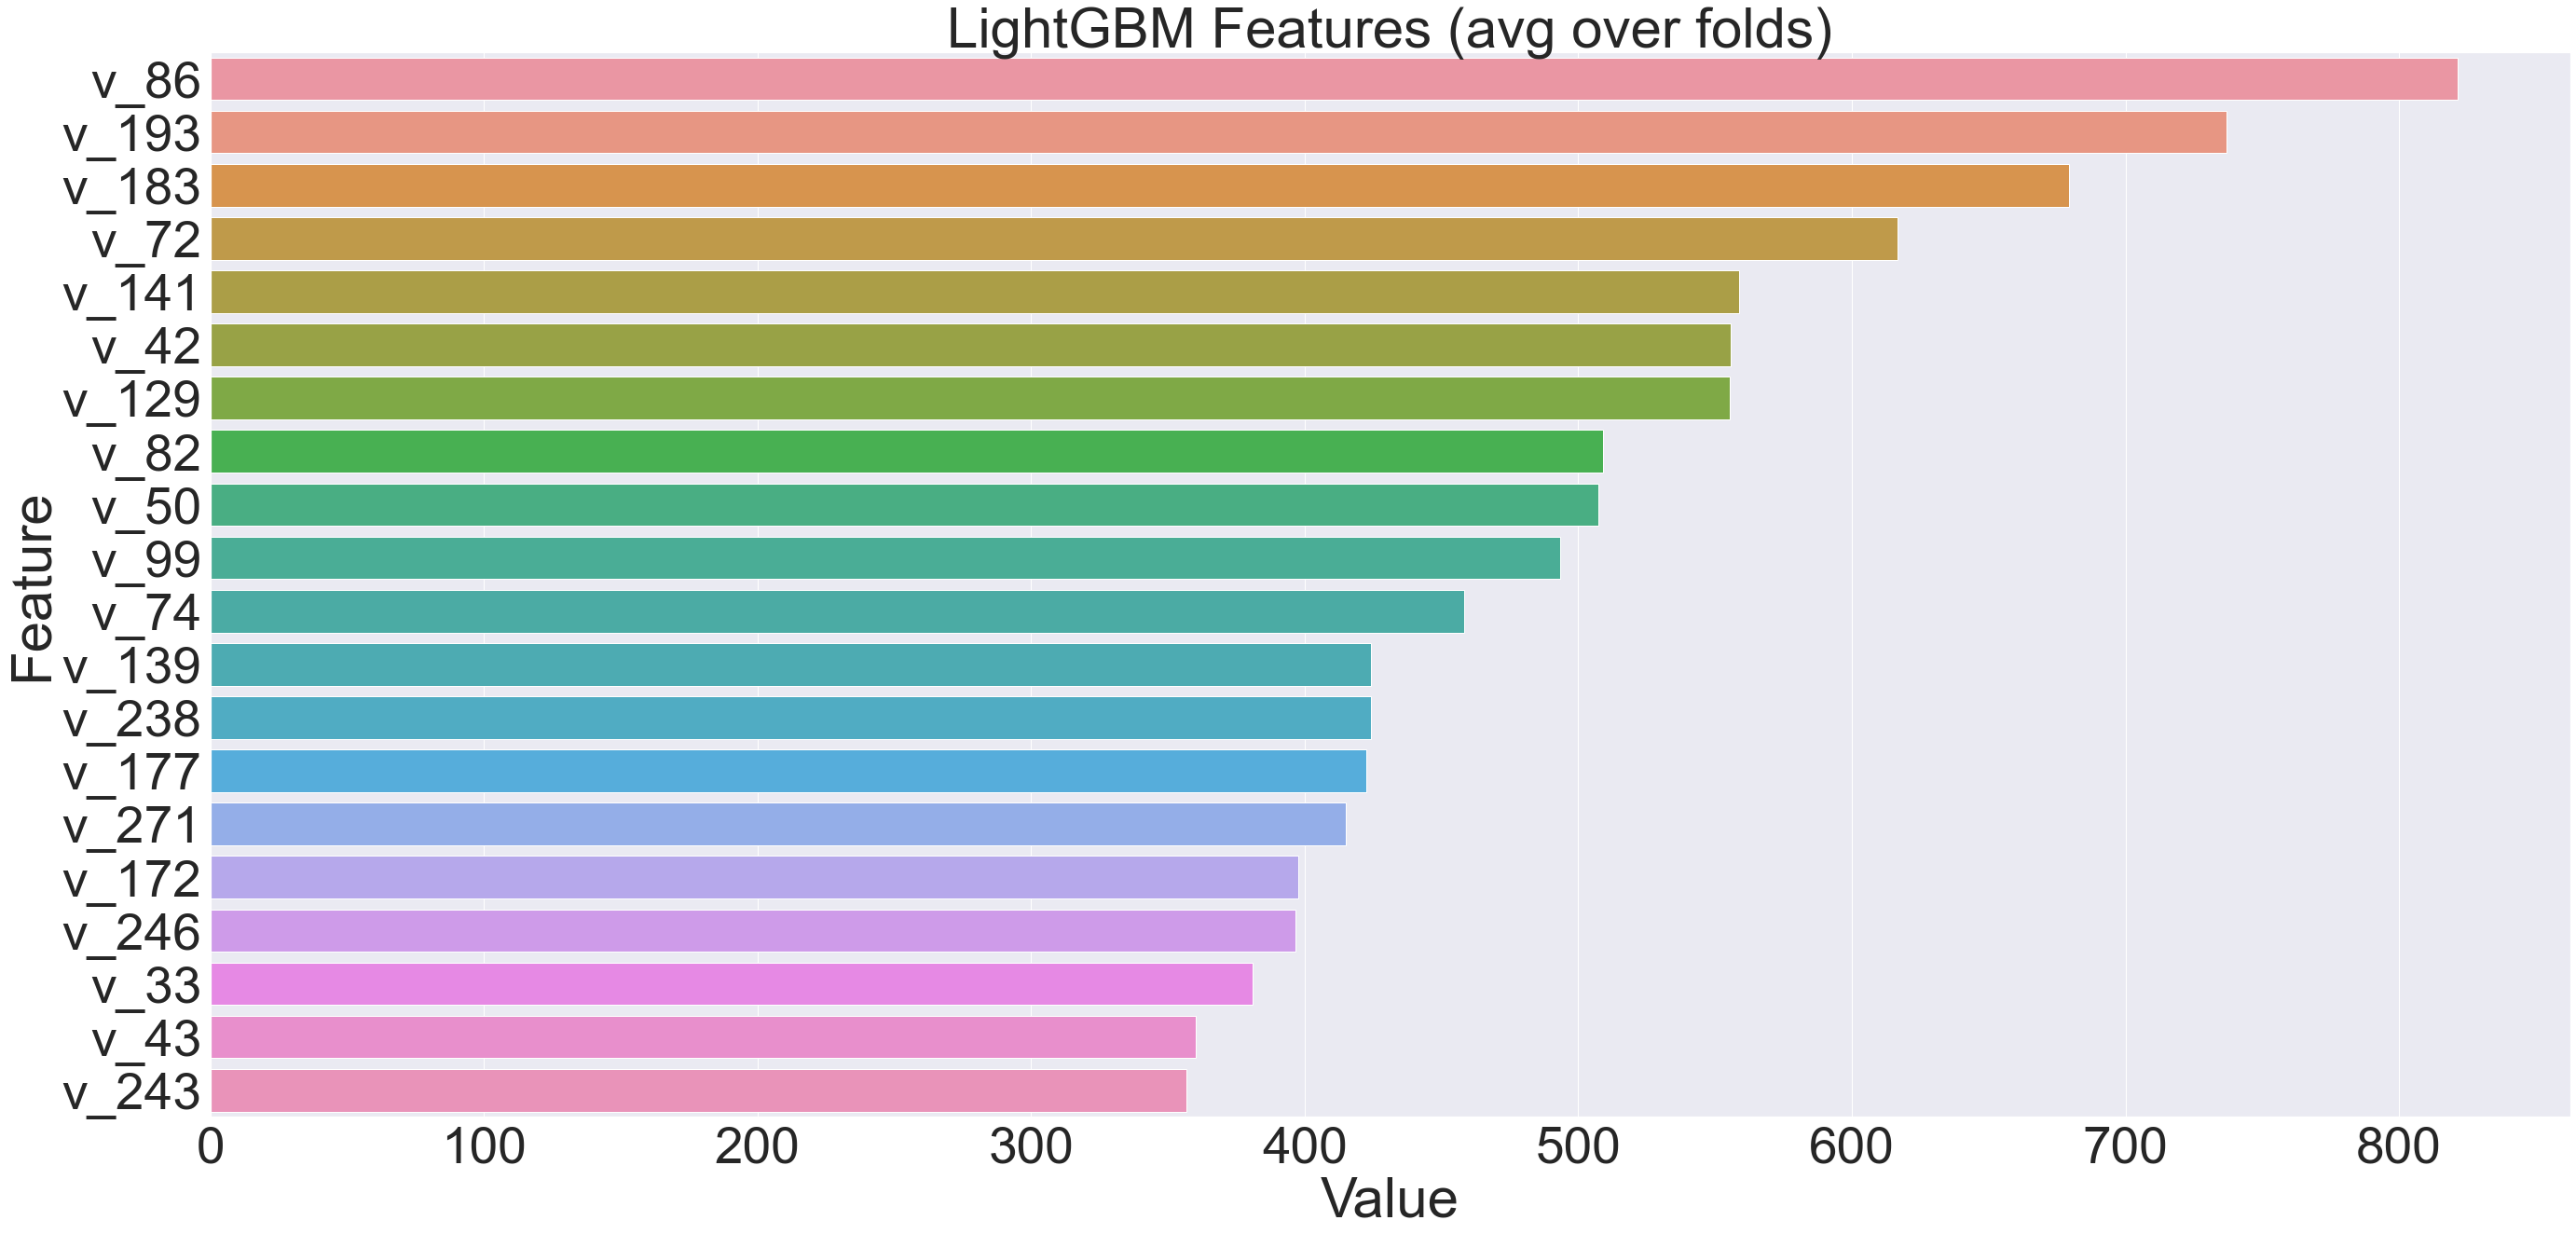

In [66]:
plotImp(estimator1, X_train, num=20, text='LightGBM Features (avg over folds)')

**Random Forest Classifier**

In [67]:
###Training of Random Forest
# estimator = RandomForestClassifier(criterion='gini',
#                            max_features='auto',
#                            random_state=100,
#                            n_jobs=-1)

# def rf_parameter(X_data, y_data):
#     n_estimators = [int(x) for x in np.linspace(100, 1000, 200)]
#     max_depth = [int(x) for x in np.linspace(5, 110, 11)]
#     max_features = ['auto', 'sqrt']
#     min_samples_split = [2, 5, 10]
#     min_samples_leaf = [1, 2, 4]
#     bootstrap = [True, False]

#     param_grid = {'n_estimators': n_estimators,
#                   'max_depth': max_depth,
#                   'max_features': max_features,
#                   'min_samples_split' : min_samples_split,
#                   'min_samples_leaf' : min_samples_leaf,
#                   'bootstrap' : bootstrap}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=StratifiedKFold(10, shuffle=True, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = rf_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [68]:
# Best parameters: {'n_estimators': 981,
#                   'min_samples_split': 10,
#                   'min_samples_leaf': 1,
#                   'max_features': 'auto',
#                   'max_depth': 15,
#                   'bootstrap': True}

In [69]:
estimator2 = RandomForestClassifier(criterion='gini', max_features='auto', random_state=100,
                                   n_estimators = 981, min_samples_split = 10, min_samples_leaf = 1,
                                   max_depth = 15, bootstrap = True,
                                   n_jobs=-1)

In [70]:
sns.set(font_scale = 1)

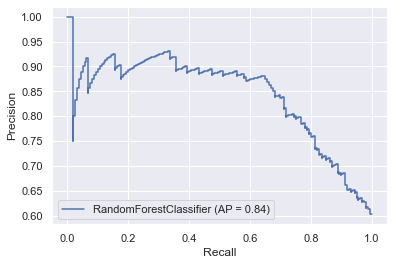

In [71]:
estimator2.fit(X_train_scaled, y_train_series)
prcurve_rf = plot_precision_recall_curve(estimator2, X_valid_scaled, y_valid_series)

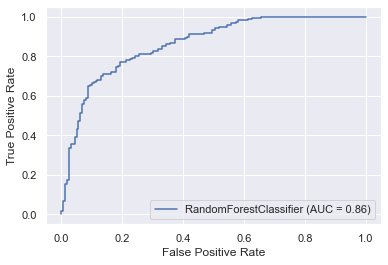

In [72]:
plot_roc_curve(estimator2, X_valid_scaled, y_valid_series);

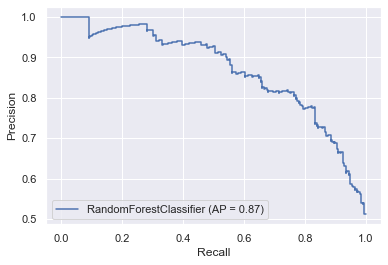

In [73]:
prcurve_rf_test = plot_precision_recall_curve(estimator2, X_test_scaled, y_test_series)

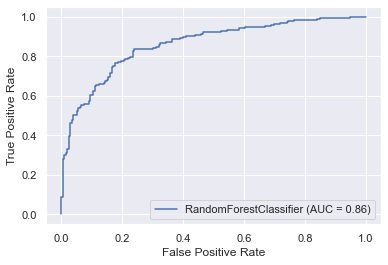

In [74]:
plot_roc_curve(estimator2, X_test_scaled, y_test_series);

**Support Vector Classifier**

In [75]:
from sklearn.svm import SVC

In [76]:
# ##Training of Support Vector Classifier
# estimator = SVC(random_state=100)

# def svc_parameter(X_data, y_data):
#     C = [1,10,100,1000]
#     gamma = [1,0.1,0.001,0.0001]
#     kernel = ['linear','rbf']

#     param_grid = {'C': C,
#                   'gamma': gamma,
#                   'kernel' : kernel}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=StratifiedKFold(10, shuffle=True, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = svc_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [77]:
# Best parameters : {'kernel': 'linear',
#                    'gamma': 1,
#                    'C': 1}

In [78]:
estimator3 = SVC(random_state=100, kernel='linear', gamma=1, C=1)

In [79]:
sns.set(font_scale = 1)

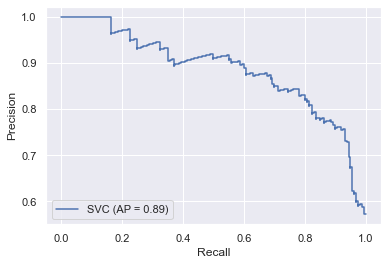

In [80]:
estimator3.fit(X_train_scaled, y_train_series)
prcurve_svc = plot_precision_recall_curve(estimator3, X_valid_scaled, y_valid_series)

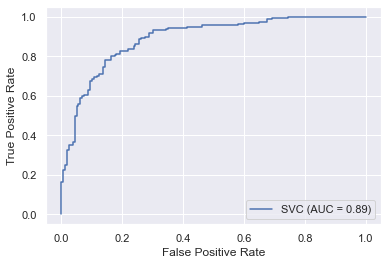

In [81]:
plot_roc_curve(estimator3, X_valid_scaled, y_valid_series);

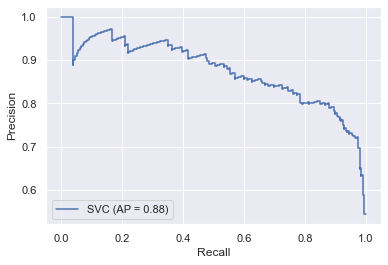

In [82]:
prcurve_svc_test = plot_precision_recall_curve(estimator3, X_test_scaled, y_test_series)

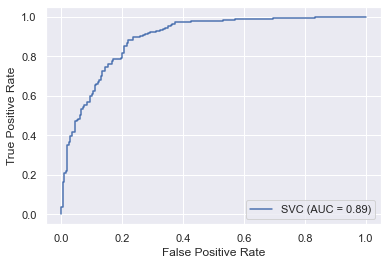

In [83]:
plot_roc_curve(estimator3, X_test_scaled, y_test_series);

**Gaussian Naive Bayes Classifier**

In [84]:
from sklearn.naive_bayes import GaussianNB

In [85]:
# ##Training of Gaussian NB
# np.random.seed(999)
# estimator = GaussianNB()

# def gnb_parameter(X_data, y_data):
#     var_smoothing = np.logspace(0,-9, num=100)

#     param_grid = {'var_smoothing': var_smoothing}
    
#     gs = RandomizedSearchCV(estimator=estimator, param_distributions=param_grid,
#                             cv=StratifiedKFold(10, shuffle=True, random_state=123),
#                             scoring="f1_micro", random_state=123, return_train_score=True, verbose=2,
#                             n_iter=50)
#     gs.fit(X_data, y_data)
#     gs.best_params_
#     return gs.best_params_

# training_start = time.perf_counter()
# best_parameter = gnb_parameter(X_train_scaled, y_train_series)
# print('Best parameters:', best_parameter)
# training_end = time.perf_counter()
# elapsed = training_end-training_start
# print("Time consumed for training: %4.3f seconds" % (elapsed))

In [86]:
# Best paramters : 'var_smoothing': 4.3287612810830526e-07

In [87]:
np.random.seed(999)
estimator4 = GaussianNB(var_smoothing=4.3287612810830526e-07)

In [88]:
sns.set(font_scale = 1)

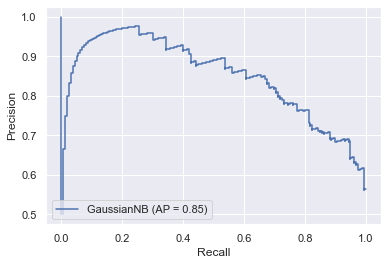

In [89]:
estimator4.fit(X_train_scaled, y_train_series)
prcurve_gnb = plot_precision_recall_curve(estimator4, X_valid_scaled, y_valid_series)

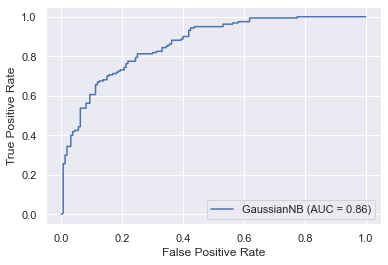

In [90]:
plot_roc_curve(estimator4, X_valid_scaled, y_valid_series);

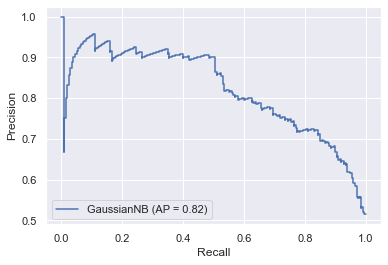

In [91]:
prcurve_gnb_test = plot_precision_recall_curve(estimator4, X_test_scaled, y_test_series)

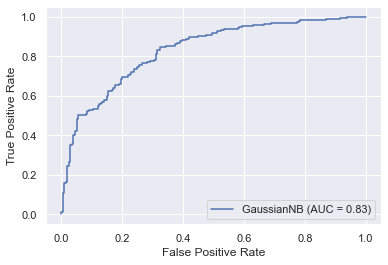

In [92]:
plot_roc_curve(estimator4, X_test_scaled, y_test_series);

**Learning Curves**

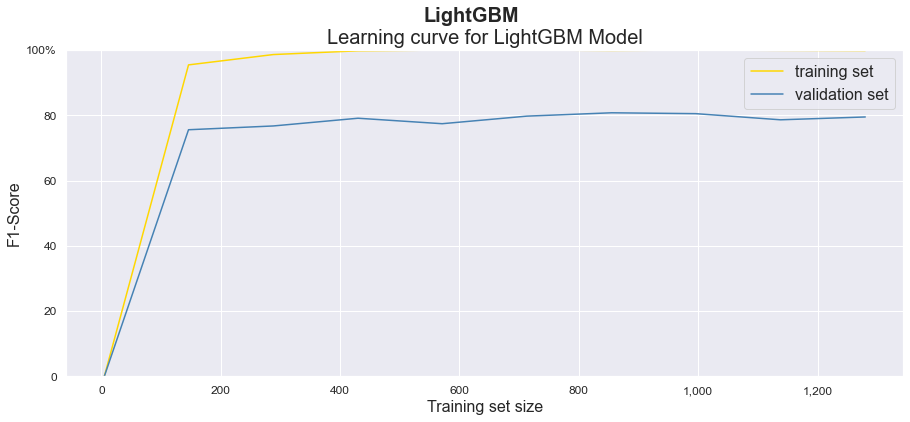

In [93]:
plot_learning_curves(estimator=estimator1,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='LightGBM',
                     title='Learning curve for LightGBM Model',
                     xlabel='Training set size',
                     ylabel='F1-Score')

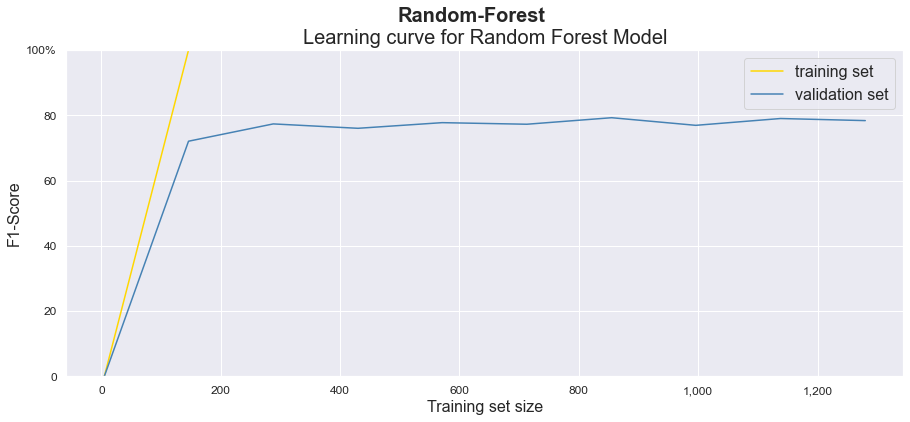

In [94]:
plot_learning_curves(estimator=estimator2,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Random-Forest',
                     title='Learning curve for Random Forest Model',
                     xlabel='Training set size',
                     ylabel='F1-Score')

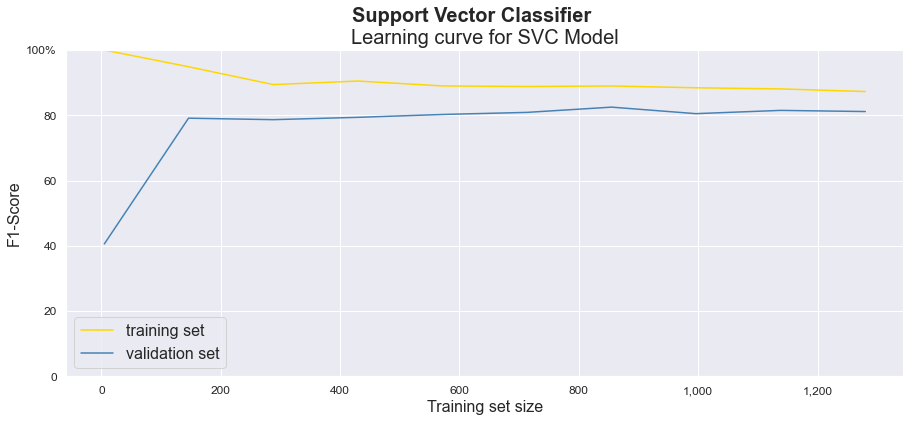

In [95]:
plot_learning_curves(estimator=estimator3,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Support Vector Classifier',
                     title='Learning curve for SVC Model',
                     xlabel='Training set size',
                     ylabel='F1-Score')

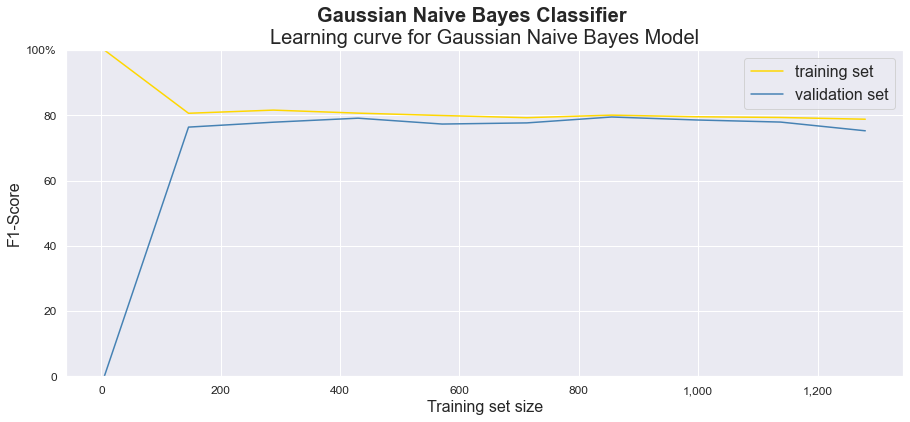

In [96]:
plot_learning_curves(estimator=estimator4,
                     X_train=pd.DataFrame(X_train_scaled),
                     y_train=y_train_series,
                     X_val=pd.DataFrame(X_valid_scaled),
                     y_val=y_valid_series,
                     suptitle='Gaussian Naive Bayes Classifier',
                     title='Learning curve for Gaussian Naive Bayes Model',
                     xlabel='Training set size',
                     ylabel='F1-Score')

**Comparisons**

In [97]:
Model = ["LightGBM", "LightGBM", "LightGBM", "LightGBM",
         "RandomForest", "RandomForest", "RandomForest", "RandomForest",
         "SVC", "SVC", "SVC", "SVC",
         "GaussianNB", "GaussianNB", "GaussianNB", "GaussianNB"]

Set = ["Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test",
       "Validation", "Validation", "Test", "Test"]

Measure = ["PR-AUC", "ROC-AUC", "PR-AUC", "ROC-AUC",
           "PR-AUC", "ROC-AUC", "PR-AUC", "ROC-AUC",
           "PR-AUC", "ROC-AUC", "PR-AUC", "ROC-AUC",
           "PR-AUC", "ROC-AUC", "PR-AUC", "ROC-AUC"]

Score = [0.87, 0.88, 0.88, 0.88,
         0.84, 0.87, 0.87, 0.86,
         0.89, 0.89, 0.88, 0.89,
         0.85, 0.86, 0.82, 0.83]

In [98]:
plot_data = pd.DataFrame([Model, Set, Measure, Score]).transpose()
plot_data.columns = ["Method", "Set", "Measure", "Score"]
plot_data["Score"] = plot_data["Score"].astype(float)

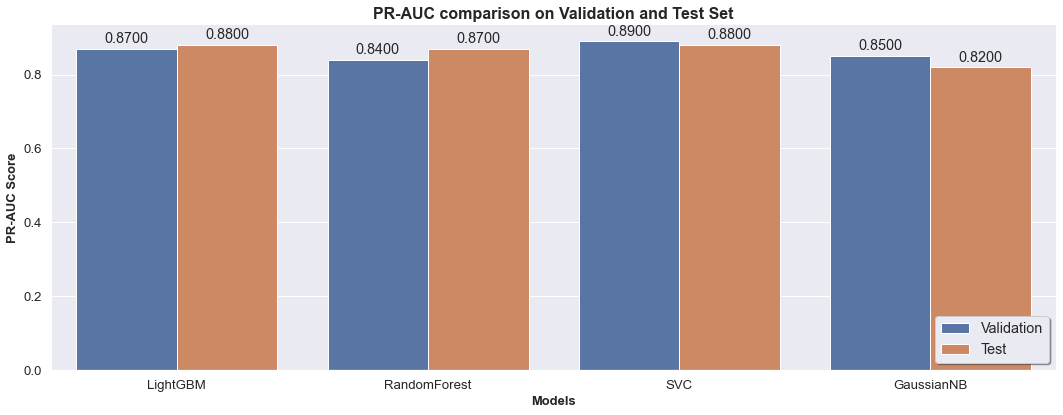

In [99]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="PR-AUC"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('PR-AUC comparison on Validation and Test Set', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('PR-AUC Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

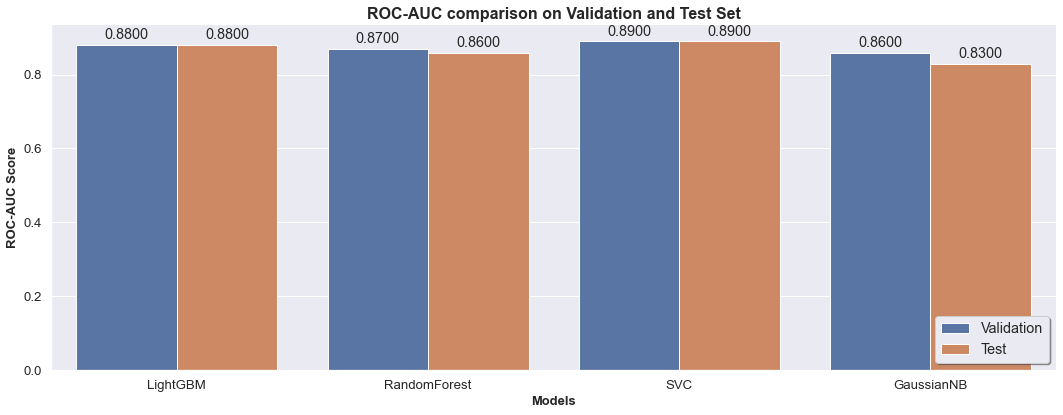

In [100]:
sns.set(font_scale = 1.2)
fig, axes = plt.subplots(figsize=(15,6))
fig.subplots_adjust(top=0.7)
splot = sns.barplot(x='Method', y="Score", hue="Set", data=plot_data[plot_data['Measure']=="ROC-AUC"], ax=axes);
axes.spines['top'].set_visible(False)
axes.spines['right'].set_visible(False)
axes.set_title('ROC-AUC comparison on Validation and Test Set', fontsize=16, weight='bold')
axes.set_xlabel('Models', fontsize=13, weight='bold')
axes.set_ylabel('ROC-AUC Score', fontsize=13, weight='bold')
axes.legend(loc='lower right', shadow=True,fontsize='medium')
##Source Code: Start
##Link : https://github.com/mwaskom/seaborn/issues/1582
for p in splot.patches:
    splot.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2.,
         p.get_height()), ha = 'center', va = 'center',
        xytext = (0, 10), textcoords = 'offset points')
##Source Code: End
# axes.legend(loc='best', shadow=True,fontsize='medium')
fig.tight_layout()
plt.show()

**Thank You**